In [1]:
import math

import pandas as pd

import analysis
import distributions
from pacing import AdServer, Auction, Campaign, AsapPacing, CumulativeEqualPacing, RecomputedEqualPacing, LinkedInPacing, AuctionEvents
from simulation import Simulation, EventCollector, Clock

In [3]:
# general settings
num_campaigns = 10
impressions_target = 1000

impressions = math.ceil(num_campaigns * impressions_target)

ticks = 24 * 60

base_dist = distributions.custom_dist(ticks)
# base_dist = distributions.uniform_dist(ticks)
traffic_dist = distributions.traffic_dist(base_dist, impressions)

In [4]:
asap = [Campaign(i, i, AsapPacing(i * impressions_target)) for i in range(1, num_campaigns + 1)]
cumulative_equal = [Campaign(i, i, CumulativeEqualPacing(i * impressions_target, ticks)) for i in
                    range(1, num_campaigns + 1)]
recomputed_equal = [Campaign(i, i, RecomputedEqualPacing(i * impressions_target, ticks)) for i in
                    range(1, num_campaigns + 1)]
linkedin = [Campaign(i, i, LinkedInPacing(i * impressions_target, traffic_dist)) for i in range(1, num_campaigns + 1)]
linkedin_hot_end = [Campaign(i, i, LinkedInPacing(i * impressions_target,
                                                  distributions.traffic_dist(base_dist, impressions_target),
                                                  2 * 60)) for i in range(1, num_campaigns + 1)]


def configure_and_run(campaigns, traffic_distribution, ticks) -> EventCollector:
    clock = Clock(ticks)
    sim = Simulation(clock)

    ec = EventCollector()

    auction = Auction(campaigns, ec)
    ad_server = AdServer(traffic_distribution, auction, campaigns)

    sim.register_process(ad_server)

    sim.run()

    return ec

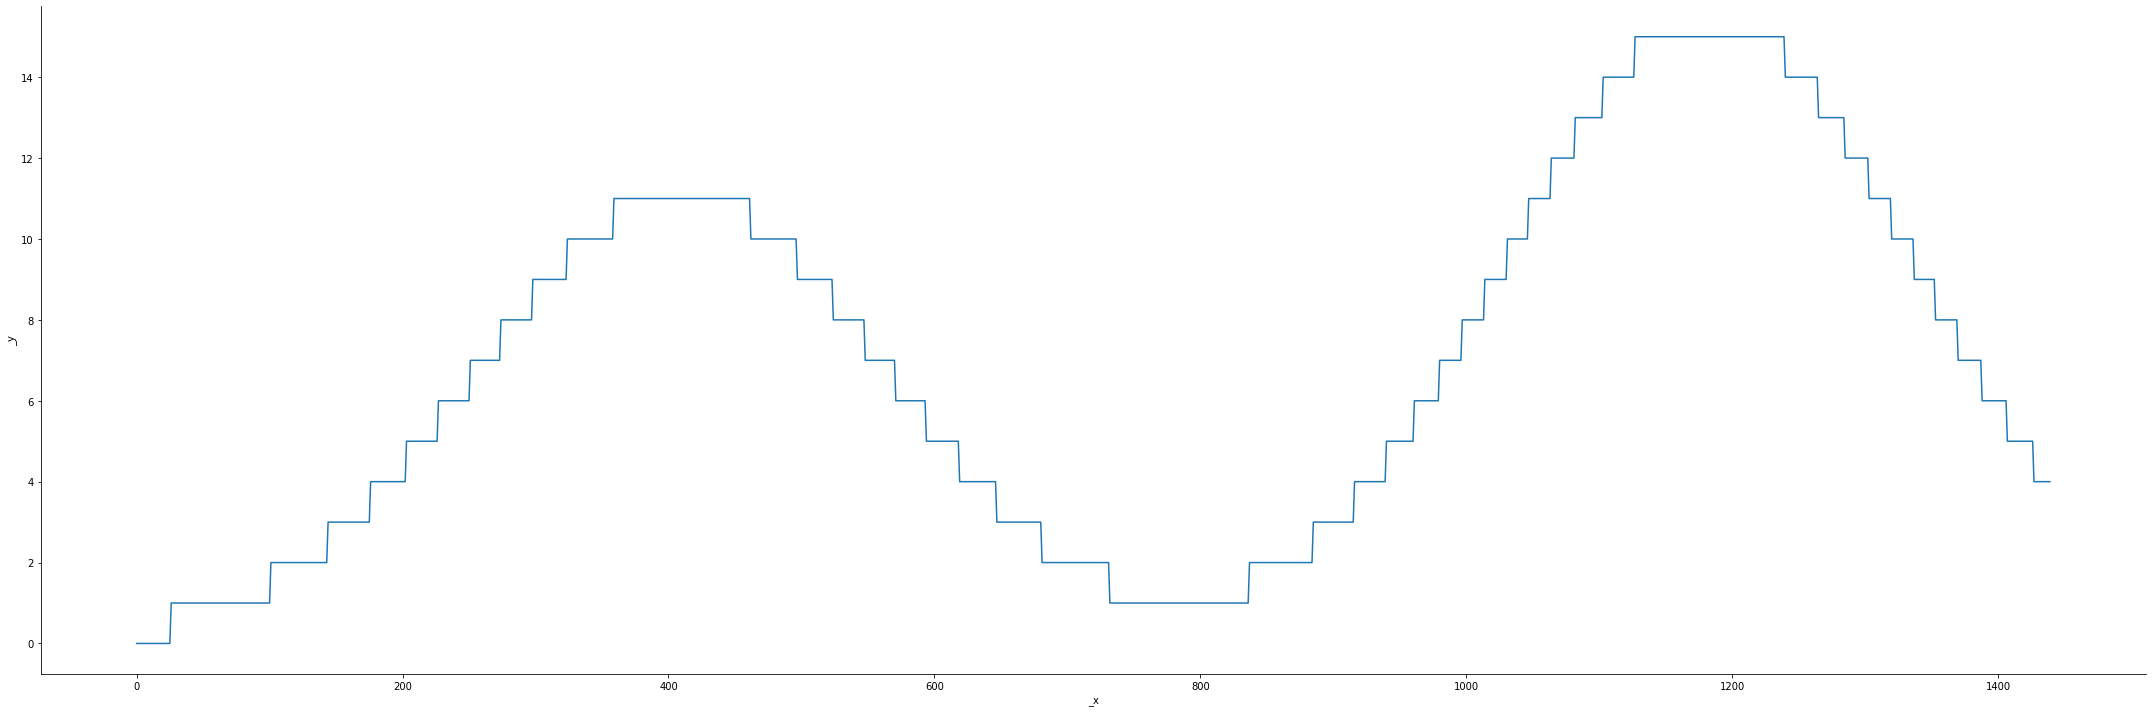

In [5]:
analysis.plot_line(traffic_dist)

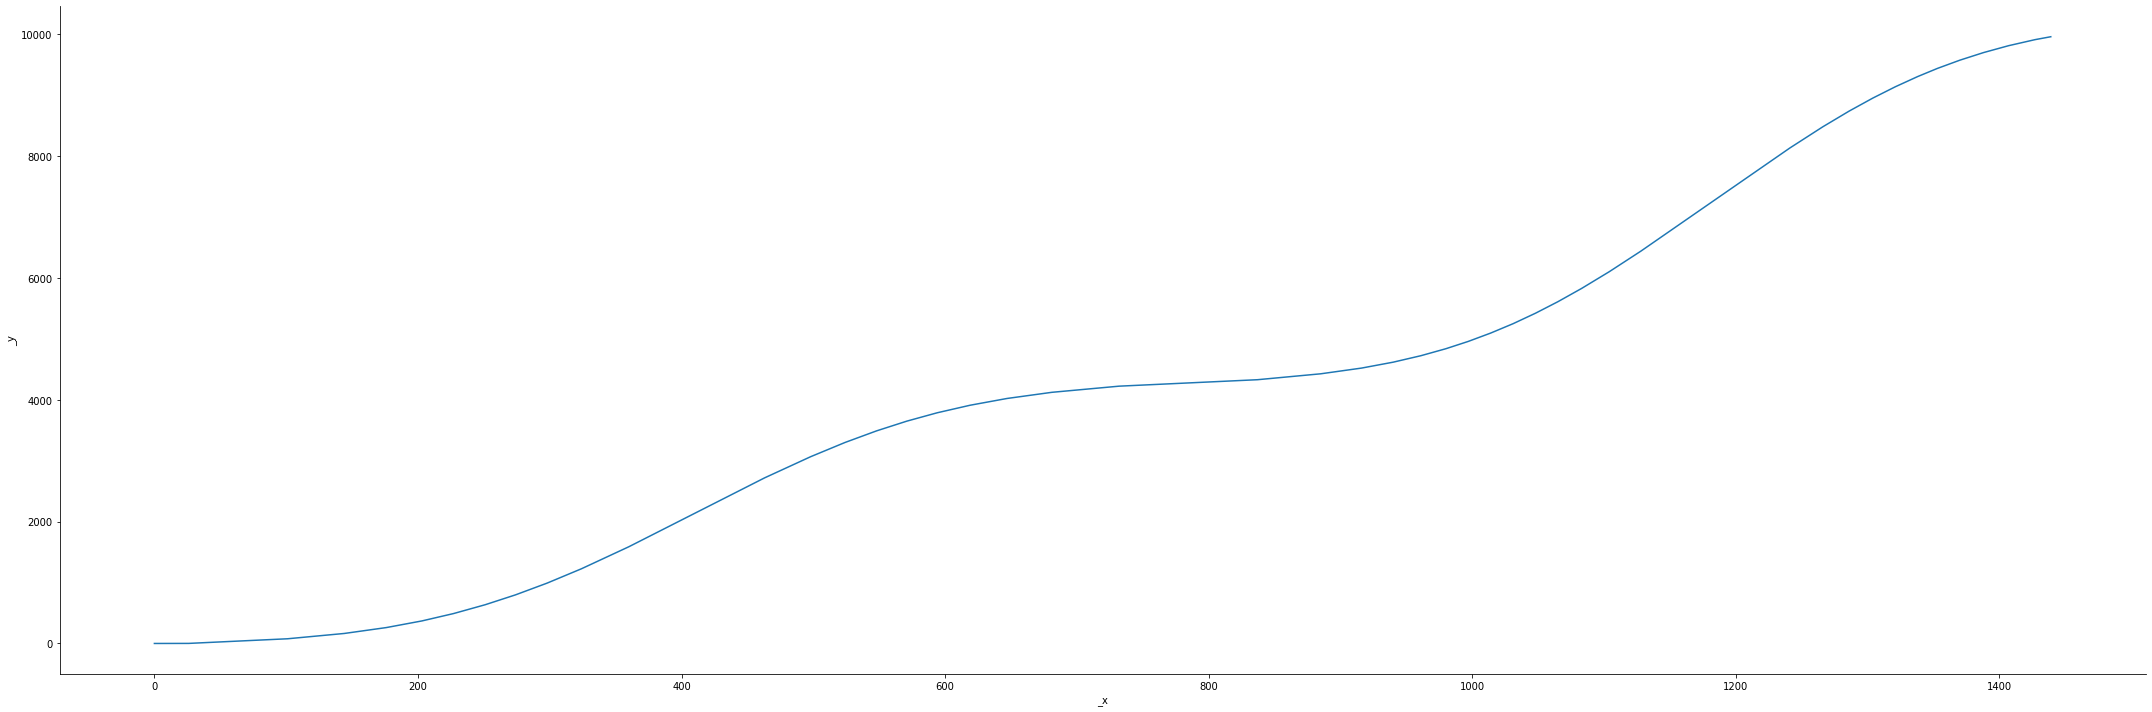

In [6]:
analysis.plot_line(traffic_dist.cumsum())

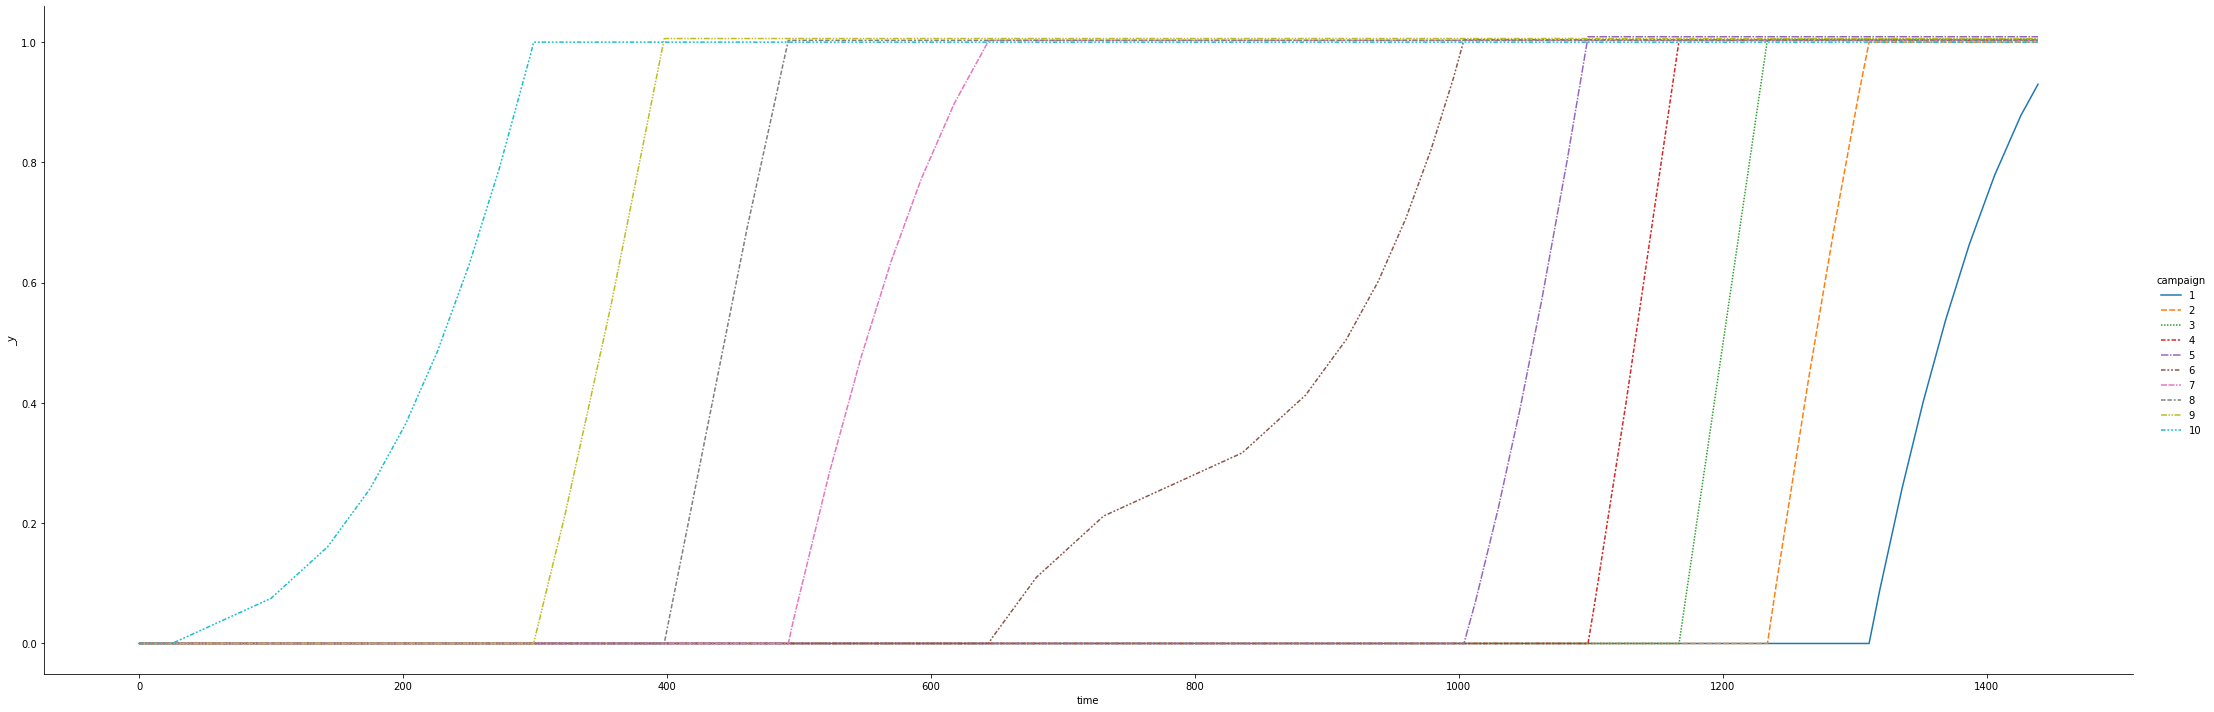

In [7]:
ec = configure_and_run(asap, traffic_dist, ticks)

wins = ec.fetch(AuctionEvents.WIN)

analysis.analyse(wins, asap, ticks)
stats_asap = analysis.stats(wins)

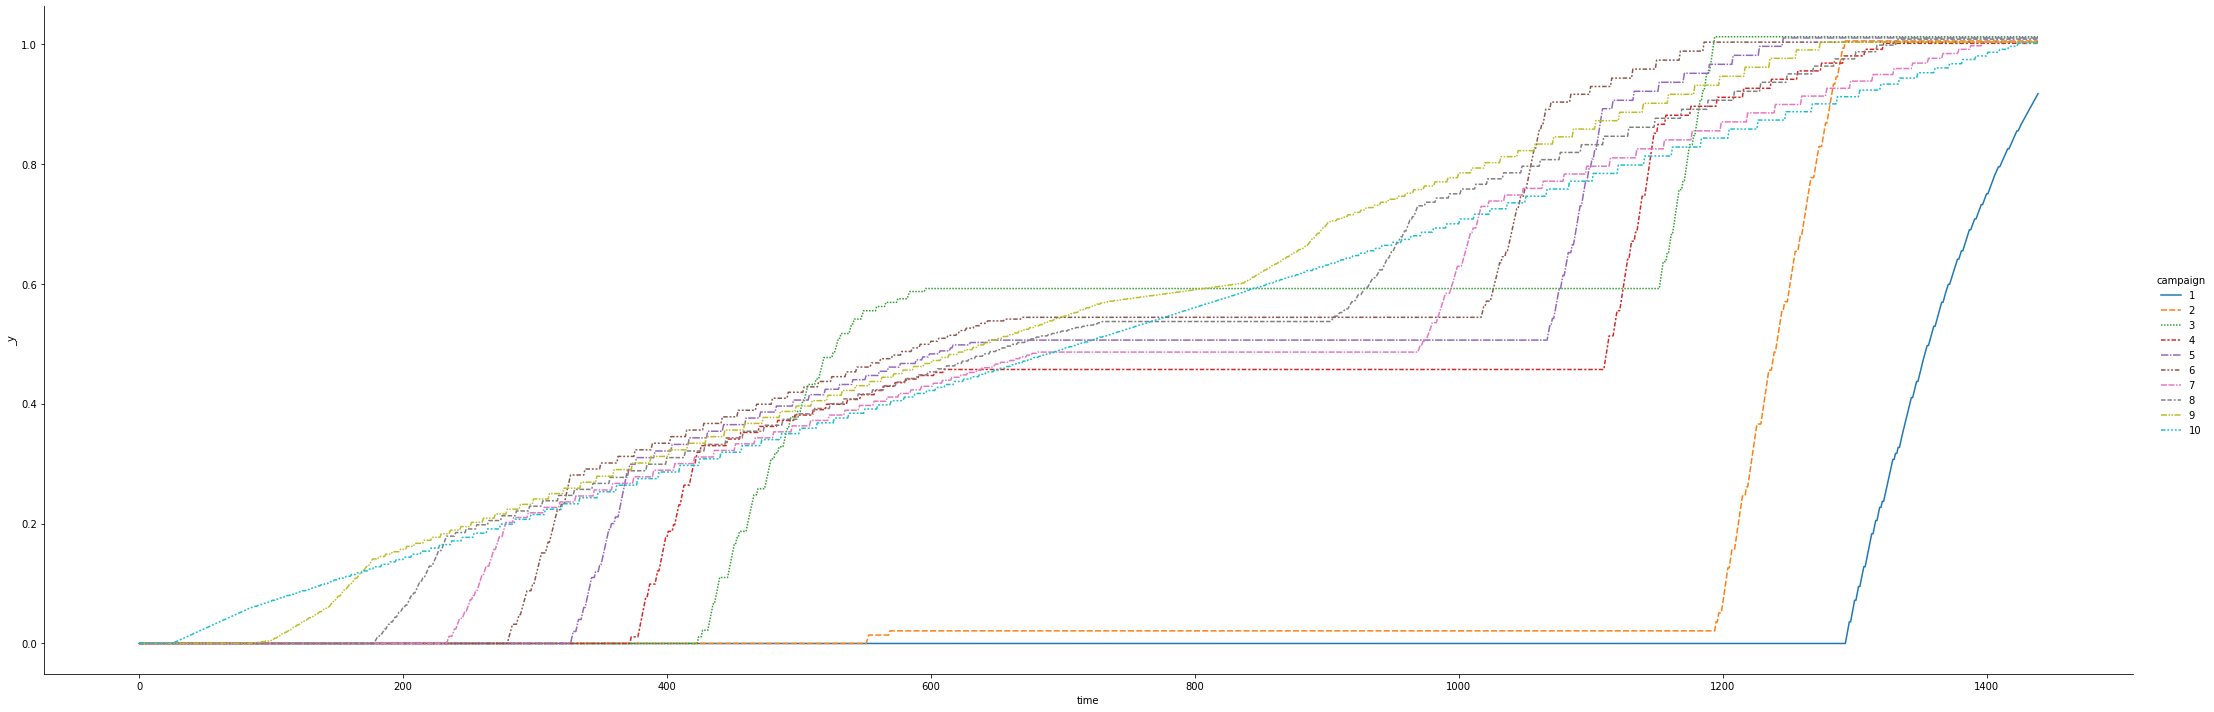

In [8]:
ec = configure_and_run(cumulative_equal, traffic_dist, ticks)

wins = ec.fetch(AuctionEvents.WIN)

analysis.analyse(wins, cumulative_equal, ticks)
stats_cum_eq = analysis.stats(wins)

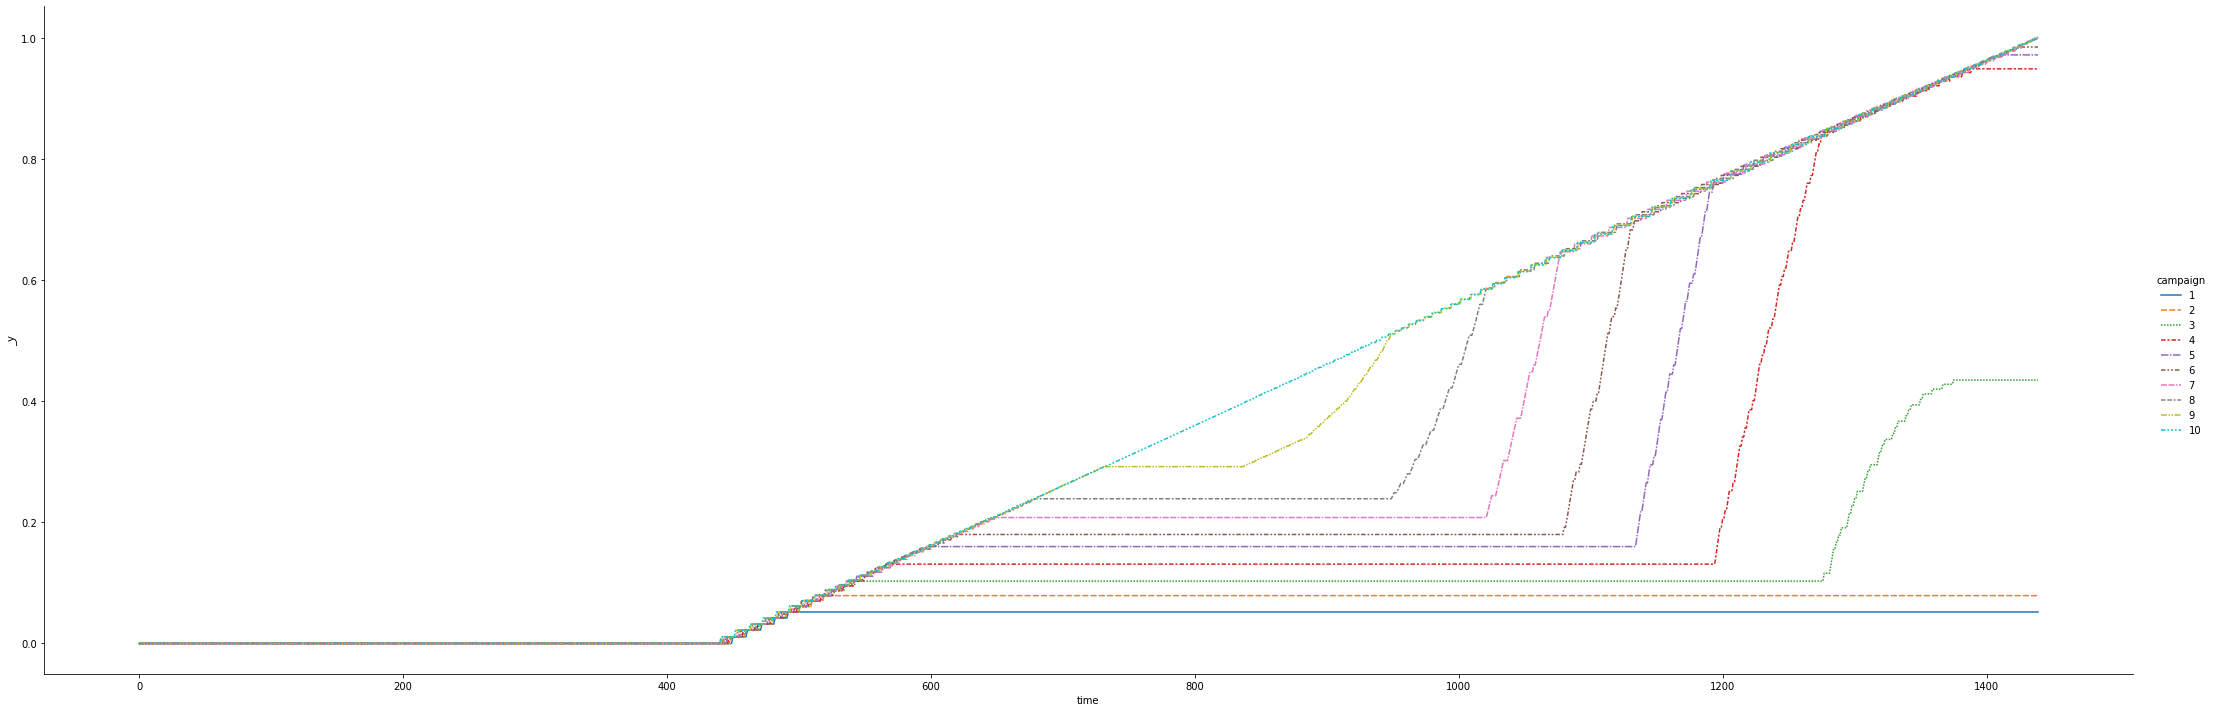

In [9]:
ec = configure_and_run(recomputed_equal, traffic_dist, ticks)

wins = ec.fetch(AuctionEvents.WIN)
analysis.analyse(wins, recomputed_equal, ticks)
stats_re_eq = analysis.stats(wins)

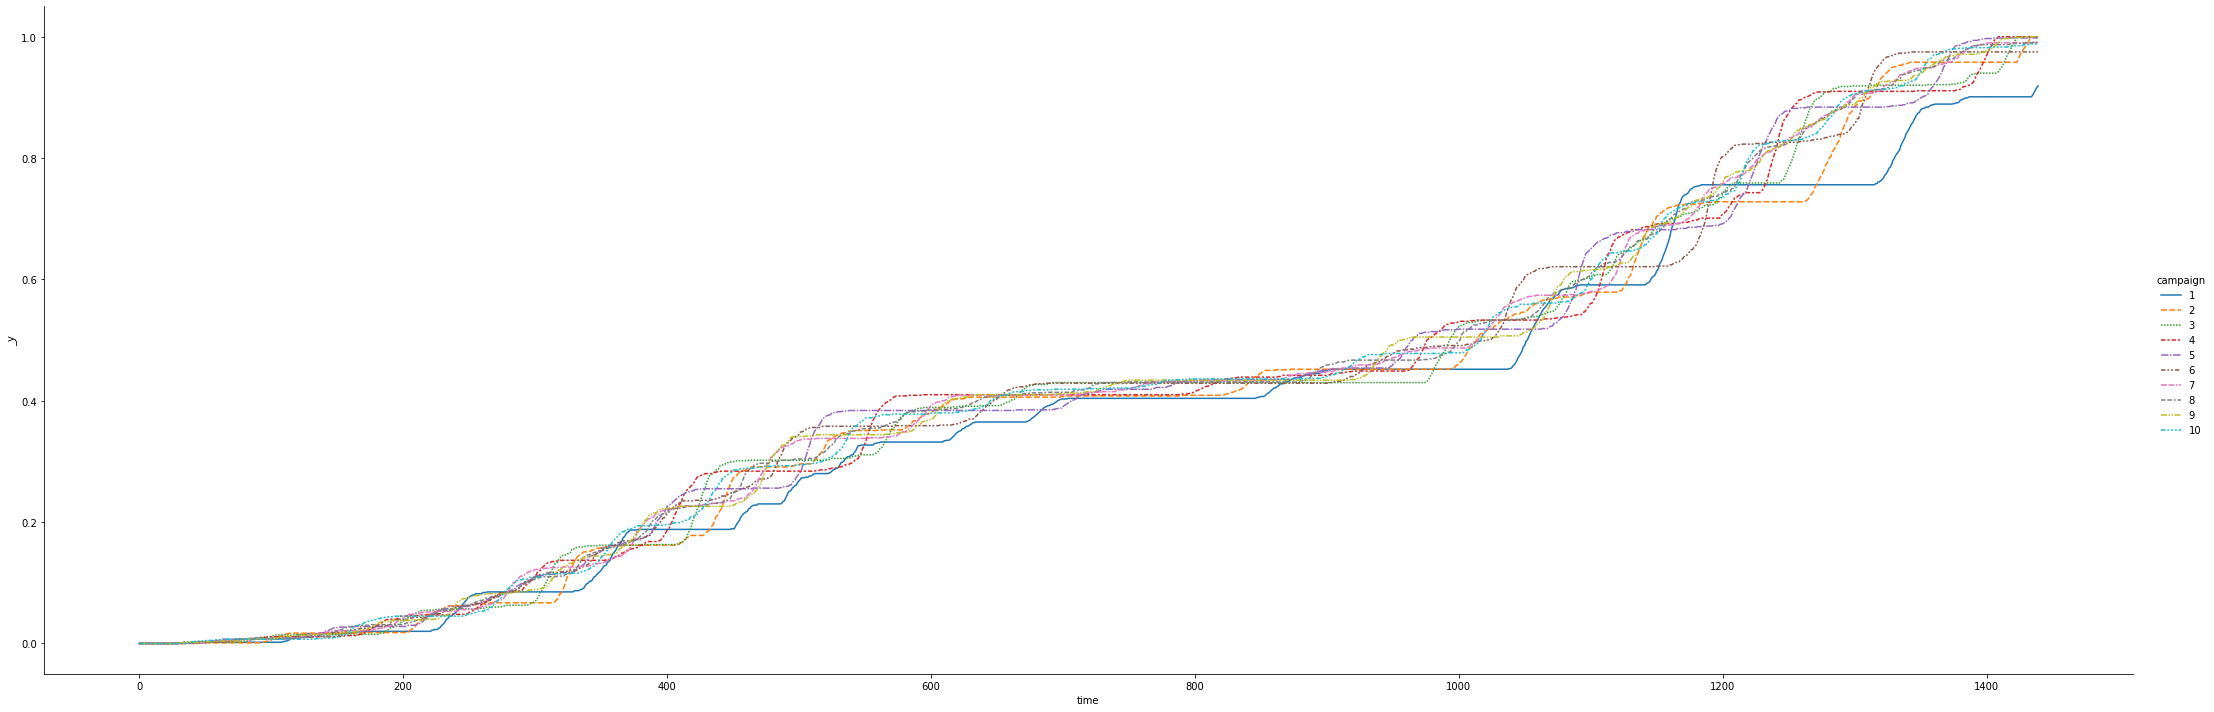

In [10]:
ec = configure_and_run(linkedin, traffic_dist, ticks)

wins = ec.fetch(AuctionEvents.WIN)
analysis.analyse(wins, linkedin, ticks)
stats_lin = analysis.stats(wins)

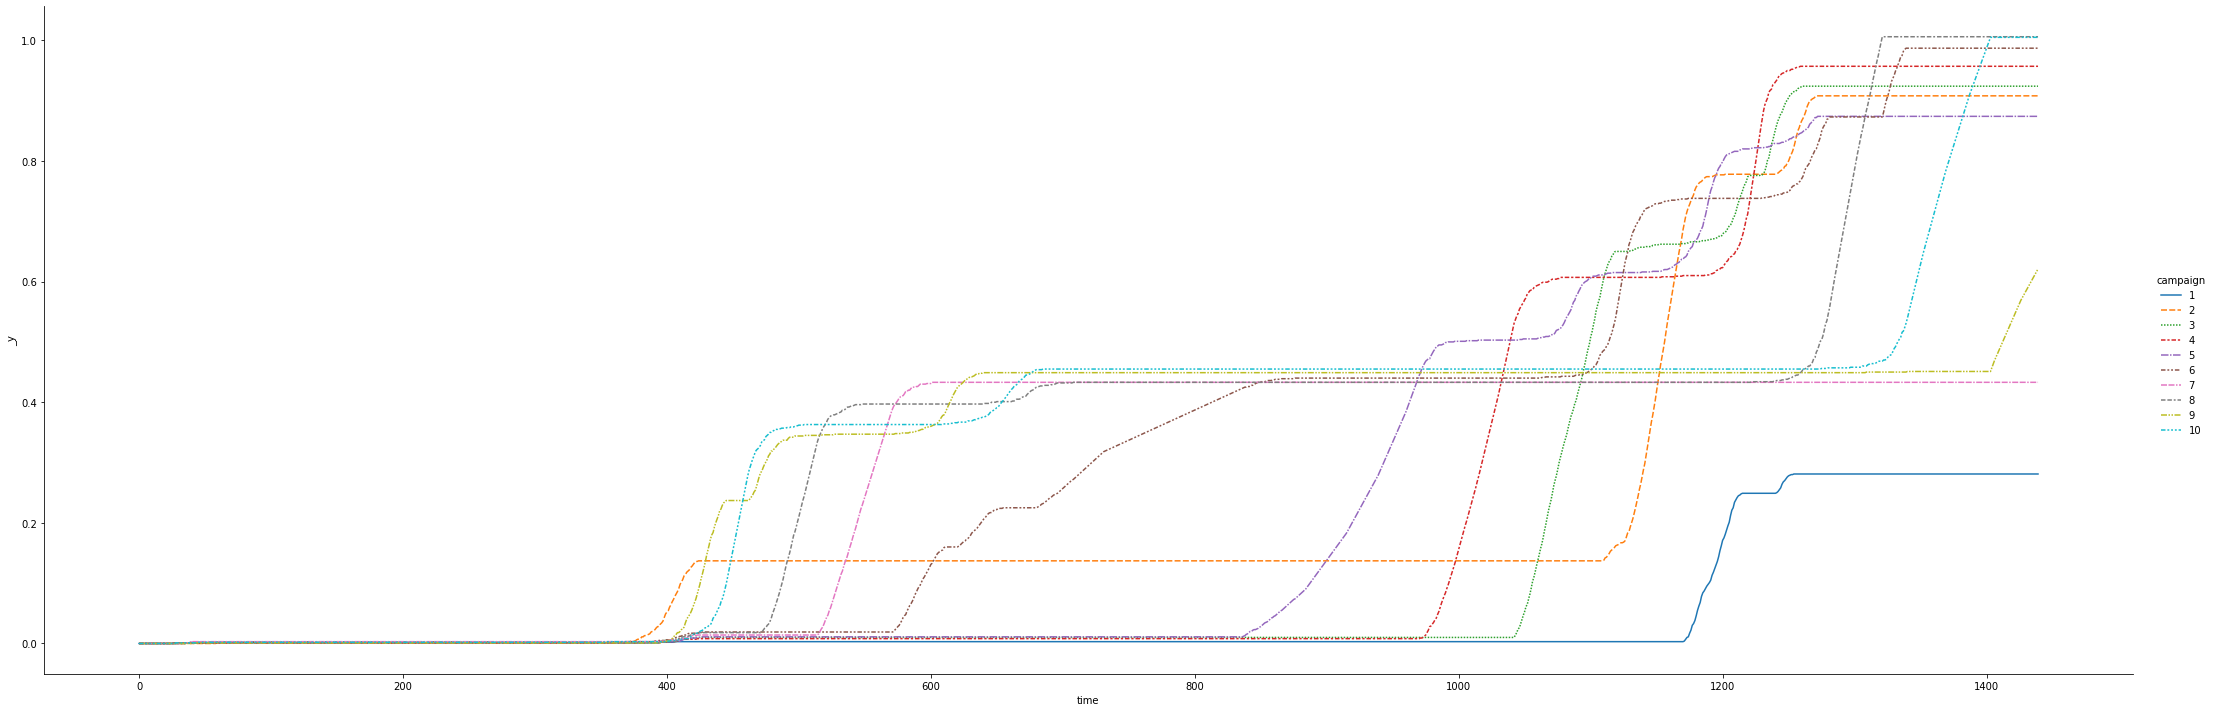

In [11]:
ec = configure_and_run(linkedin_hot_end, traffic_dist, ticks)

wins = ec.fetch(AuctionEvents.WIN)
analysis.analyse(wins, linkedin_hot_end, ticks)
stats_lin_he = analysis.stats(wins)

In [12]:
t_size_df = pd.DataFrame({
    "asap": stats_asap["t_size"],
    "cum_eq": stats_cum_eq["t_size"],
    "re_eq": stats_re_eq["t_size"],
    "lin": stats_lin["t_size"],
    "lin_he": stats_lin_he["t_size"],
})

In [13]:
import numpy as np

t_size_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,141.4,934.1,791.1,1383.6,1207.7
median,96.5,934.5,971.0,1390.5,1236.5


In [14]:
t_uniq_df = pd.DataFrame({
    "asap": stats_asap["t_uniq"],
    "cum_eq": stats_cum_eq["t_uniq"],
    "re_eq": stats_re_eq["t_uniq"],
    "lin": stats_lin["t_uniq"],
    "lin_he": stats_lin_he["t_uniq"],
})
t_uniq_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,141.4,141.4,99.7,460.7,188.2
median,96.5,114.5,85.5,440.5,167.0


In [15]:
imps_df = pd.DataFrame({
    "asap": stats_asap["imps"],
    "cum_eq": stats_cum_eq["imps"],
    "re_eq": stats_re_eq["imps"],
    "lin": stats_lin["imps"],
    "lin_he": stats_lin_he["imps"],
})
imps_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,996.3,996.3,747.4,986.2,799.6
median,1003.0,1003.0,978.5,995.0,916.0


In [16]:
discr = imps_df - impressions_target

In [17]:
discr.abs().agg([np.sum, np.mean, np.median, np.min, np.max])

,asap,cum_eq,re_eq,lin,lin_he
sum,103.0,129.0,2532.0,138.0,2026.0
mean,10.3,12.9,253.2,13.8,202.6
median,3.5,4.0,21.5,5.0,84.0
amin,0.0,1.0,0.0,0.0,5.0
amax,70.0,83.0,948.0,81.0,719.0


In [18]:
under = discr.copy()

In [19]:
under[under > 0] = 0

In [20]:
under

,asap,cum_eq,re_eq,lin,lin_he
campaign,,,,,
1,-70,-83,-948,-81,-719
2,0,0,-921,0,-92
3,0,0,-565,0,-76
4,0,0,-51,0,-43
5,0,0,-28,-2,-126
6,0,0,-15,-25,-13
7,0,0,-1,-10,-567
8,0,0,0,-8,0
9,0,0,0,0,-379


In [21]:
under.agg([np.sum, np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
sum,-70.0,-83.0,-2529.0,-138.0,-2015.0
mean,-7.0,-8.3,-252.9,-13.8,-201.5
median,0.0,0.0,-21.5,-5.0,-84.0


In [22]:
over = discr.copy()

In [23]:
over[over < 0] = 0

In [24]:
over

,asap,cum_eq,re_eq,lin,lin_he
campaign,,,,,
1,0,0,0,0,0
2,0,5,0,0,0
3,5,12,0,0,0
4,3,1,0,0,0
5,9,10,0,0,0
6,4,3,0,0,0
7,3,3,0,0,0
8,3,8,2,0,6
9,6,3,1,0,0


In [25]:
over.agg([np.sum, np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
sum,33.0,46.0,3.0,0.0,11.0
mean,3.3,4.6,0.3,0.0,1.1
median,3.0,3.0,0.0,0.0,0.0
